# Econtrando o centro da galáxia

Em uma atividade passada foi sugerido o exercício de encontrar o fluxo no centro da galáxia, utilizando para isso uma imagem da galáxia em um determinado filtro. Normalmente estamos interessados no fluxo dentro de uma certa região. Por exemplo: qual é o fluxo dentro de um círculo de 1 arcosegundo de raio centrado no núcleo da galáxia?

Para responder isso precisamos antes descobrir em qual pixel está o núcleo da galáxia.
Se soubessemos de antemão as coordenadas em algum sistema, como o sistema equatorial, poderíamos converter as coordenadas de ascenção reta e declinação para pixeis, e estaria resolvido o problema.
Contudo, vamos fazer o exercício de encontrar o centro da galáxia partindo apenas da imagem, e supondo que o centro que nos importa é o ponto onde o fluxo é mais intenso, o que se traduz no pixel de maior valor.

Começamos importando os pacotes necessários para ler o arquivo que contém a imagem.

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
%matplotlib qt

Agora carregamos a imagem na memória do computador e fazemos um gráfico preliminar.

In [3]:
image = fits.getdata('Imagens de galaxia/frame-u-006793-1-0130.fits.bz2')
plt.imshow(image, vmin=0, vmax=2, origin='lower')
plt.grid(alpha=0.3)

Olhando assim por cima já podemos arriscar um palpite para o centro da galáxia.
Deve ser o pixel mais intenso, certo?
A julgar pela porção de pixeis saturados ali pela coordenada $x, y = 1500, 1000$, e que o fluxo cai conforme nos afastamos desse ponto em qualquer direção, o centro da galáxia deve ser mesmo ali nos $1500, 1000$.

Será que essa é a coordenada do pixel de mais alto fluxo na imagem?

In [4]:
np.where(image == image.max())

(array([851], dtype=int64), array([1218], dtype=int64))

Parece que algo deu errado. O pixel mais intenso é o (1130, 941), que está meio longe do centro da galáxia.

Pensando bem, até faz sentido. Ninguém garante que a galáxia é o objeto mais brilhante nessa imagem. É perfeitamente possível que exista no campo uma estrela próxima com fluxo muito maior. Por óbvio a galáxia é intrinsicamente mais brilhante que a estrela, mas está muito mais longe do que a estrela.

Então nossa primeira tentativa de encontrar a coordenada do centro da galáxia falhou miseravelmente. Porém, nosso palpite do "olhômetro" não estava tão ruim assim.

O que vamos tentar fazer a seguir é refinar esse palpite, e obter um método quantitativo para descobrir o centro da galáxia.
Ao final do exercício vamos ter calculado o "centro de massa" da imagem da galáxia, mas vamos com calma.

## Máscaras

Antes de prosseguir vamos tratar do assunto das máscaras, ou indexação booleana.
Sempre que for preciso selecionar um certo conjunto de elementos de um vetor, supondo que os nossos elementos sejam satisfeitos por alguma sentença lógica, podemos utilizar máscaras.
Essa máscara nada mais é do que um vetor de elementos booleanos, uma sequência de elementos com os valores verdadeiro e falso.

Aqui vai um exemplo:

In [5]:
a = np.array([1, 2, 3, 4, 5])
b = np.array([False, True, False, False, True])
print(a[b])

[2 5]


Viram? O vetor `a` tinha os elementos 1, 2, 3, 4 e 5, e o `b` era todo falso, a não ser no segundo e quinto elementos. Se pedirmos para acessar os índices `b` do vetor `a`, vamos receber de volta só os elementos de `a` em que `b` era verdadeiro.

Se tivermos um vetor gigante com milhões de elementos, como o vetor da nossa imagem, não vamos poder ir escevendo `True` e `False` individualmente.
Nesse caso a maneira mais prática é com operadores lógicos, que se aplicam a cada elemento de um vetor individualmente.

In [6]:
print(a > 2)

[False False  True  True  True]


Neste exemplo, vemos o resultado da operação lógica `a > 2`, que retorna verdadeiro sempre que o elemento de `a` for maior do que 2, e falso sempre que ele for menor. Trocando em miúdos, é verdadeiro quando a condição é satisfeita, e falso quando não é satisfeita.

Podemos inclusive usar o próprio `a` para criar uma máscara para `a`.

In [7]:
print(a[a > 2])

[3 4 5]


Aqui queremos apenas os valores de `a` que são maiores do que 2. Essa maneira de fatiar vetores utilizando máscaras produz o mesmo efeito que obter fatias pela especificação dos índices.

Se quisermos os elementos de `a` entre o terceiro e sexto elementos, por exemplo:

In [8]:
print(a[2:5])

[3 4 5]


Dominada a questão das máscaras, é hora de utilizarmos elas para selecionar um pedaço da imagem. Vamos começar com uma definição de coordenadas. A função de `numpy.indices` retorna vetores de coordenadas que preenchem uma forma fornecida. Por exemplo, nossa imagem é um vetor de duas dimensões, ou uma matriz, de 2048x1489 pixeis, como podemos ver no atributo `shape` do objeto `image`. 

In [9]:
image.shape

(1489, 2048)

Vale lembrar que em Python as matrizes são dadas em linhas por colunas, ou seja, y antes e x depois.

In [10]:
y, x = np.indices(image.shape)
print('x =', x)
print('y =', y)

x = [[   0    1    2 ... 2045 2046 2047]
 [   0    1    2 ... 2045 2046 2047]
 [   0    1    2 ... 2045 2046 2047]
 ...
 [   0    1    2 ... 2045 2046 2047]
 [   0    1    2 ... 2045 2046 2047]
 [   0    1    2 ... 2045 2046 2047]]
y = [[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1486 1486 1486 ... 1486 1486 1486]
 [1487 1487 1487 ... 1487 1487 1487]
 [1488 1488 1488 ... 1488 1488 1488]]


Essas matrizes `x` e `y` nos permitem trabalhar com as coordenadas de cada pixel de uma maneira programática.
Podemos, por exemplo, construir uma matriz de distâncias, que nos dê a distância radial de cada pixel com respeito ao nosso palpite para o centro da galáxia.

$$ x_0, y_0 = 1500, 1000 $$

In [15]:
x0, y0 = 1500, 1000
r = np.sqrt((x - x0)**2 + (y - y0)**2)
plt.imshow(y, origin='lower')
plt.colorbar()

A imagem acima é uma representação gráfica dessa matriz, que vale 0 em (1500, 1000), e vai aumentando conforme nos afastamos.
Uma matriz desse tipo é util se quisermos selecionar uma parte da imagem.
Como faríamos para selecionar todos os pixeis que estão a menos de uma certa distância de centro da galáxia?

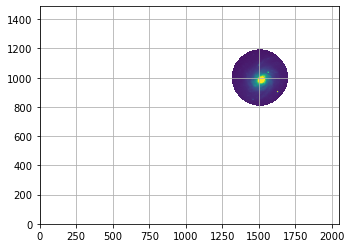

In [49]:
a = image.copy()
a[r > 200] = np.nan 
plt.imshow(a, origin='lower', vmax=10)
plt.grid()

A slice `r > 200` vai retornar verdadeiro sempre que o valor de `r` for maior do que 200, produzindo portanto uma máscara. Essa máscara pode ser utilizada para fazer com que todos os pixeis de `a` coincidentes com um valor verdadeiro da máscara recebam o valor que está do lado direito da igualdade, no caso, `np.nan`, ou seja `Not A Number`.
O resultado é uma imagem cujos únicos pixeis que possuem um valor numérico, e logo são representados por uma cor, são aqueles que satisfazem `r < 200`.

Será que agora conseguimos achar o centro com o pixel de maior fluxo? Vamos tentar fazer todos os outros serem zero, certamente o que sobrar deve ser o centro da galáxia.

In [50]:
a[r > 200] = 0
np.where(a == a.max())

(array([985], dtype=int64), array([1512], dtype=int64))

Parece que agora estamos chegando perto. Contudo, é um pouco temerário basear nossa definição do centro da galáxia num único pixel solitário.

## Centro de massa

Uma das maneiras mais práticas de se encontrar o centro uma estrutura em uma imagem é através do seu "centro de massa". A ideia é simplesmente calcular uma média ponderada de coordenadas pesada pela massa, ou no nosso caso, pelo fluxo. Isso serve muito bem para galáxias por que sabemos que elas são mais brilhantes no centro, e esse aumento de brilho em direção ao centro é razoavelmente bem comportado, mesmo para sistemas mais complexos como galáxias espirais.

Vamos utilizar as nossas matrizes de coordenadas `x` e `y` de antes para tentar calcular esse centro de massa.

In [51]:
x_cm = np.sum(x * image) / image.sum()
y_cm = np.sum(y * image) / image.sum()
print(x_cm, y_cm)

1418.2680582466805 903.7030117726586


In [52]:
image

array([[ 0.15136719, -0.25830078,  0.18530273, ..., -0.22460938,
        -0.0227356 , -0.15722656],
       [-0.08764648,  0.18530273, -0.08764648, ..., -0.12365723,
        -0.05633545, -0.19091797],
       [-0.15600586, -0.12182617, -0.05352783, ...,  0.27978516,
        -0.25830078,  0.01092529],
       ...,
       [ 0.28515625, -0.09033203,  0.04620361, ..., -0.02548218,
         0.07543945,  0.00813293],
       [-0.02206421,  0.08032227, -0.29492188, ...,  0.04174805,
         0.17626953,  0.10900879],
       [ 0.14868164,  0.08032227, -0.32910156, ..., -0.05914307,
        -0.12646484,  0.07531738]], dtype=float32)

In [53]:
x

array([[   0,    1,    2, ..., 2045, 2046, 2047],
       [   0,    1,    2, ..., 2045, 2046, 2047],
       [   0,    1,    2, ..., 2045, 2046, 2047],
       ...,
       [   0,    1,    2, ..., 2045, 2046, 2047],
       [   0,    1,    2, ..., 2045, 2046, 2047],
       [   0,    1,    2, ..., 2045, 2046, 2047]])

Aí já vemos que o centro de massa geral não está longe da nossa galáxia. Para melhorar a estimativa vamos nos concentrar só na região que tínhamos definido antes, em um raio de 200 pixeis do palpite inicial.

In [54]:
x_cm = np.sum(x * a) / a.sum()
y_cm = np.sum(y * a) / a.sum()
print(x_cm, y_cm)

1510.0872475359865 985.2882285317756


Opa, agora sim! E ainda por cima chegamos num valor muito próximo do pixo de fluxo que acabamos de achar.
Agora vamos tentar colocar tudo isso na forma de um função, para fazermos mais umas experiências.

Funções em Python são pequenos pedaços de código que podem ser invocados com alguns argumentos. Por exemplo, podemos criar uma função que multiplique o número dado por dois.

In [55]:
def multiplique_por_dois(x):
    return x * 2

E agora sempre que quisermos chamar a função basta fazer

In [56]:
multiplique_por_dois(5)

10

In [57]:
multiplique_por_dois(7)

14

Essa função não é a coisa mais útil do mundo, mas apenas para demonstrar a ideia basica. O que vamos fazer agora é uma função que calcule o centro de massa da imagem dado um palpite inicial e um raio, ou seja, exatamente o que acabamos de fazer.

In [58]:
def center_of_mass(data, x0, y0, radius):
    y, x = np.indices(data.shape)
    r = np.sqrt((x - x0)**2 + (y - y0)**2)
    mask = r < radius
    x_cm = np.sum(x[mask] * data[mask]) / data[mask].sum()
    y_cm = np.sum(y[mask] * data[mask]) / data[mask].sum()
    return x_cm, y_cm

center_of_mass(image, 1500, 1000, 200)

(1510.0870841137214, 985.2886672063032)

Escrever as coisas em funções facilita muito a vida. Digamos que estejamos disconfiados da nossa solução, e queremos testar a estabilidade da resposta. Será que mudar o raio muda o resultado? 

Text(0, 0.5, 'x do centro de massa')

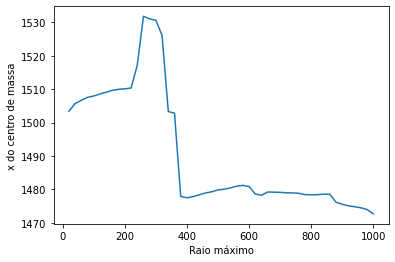

In [59]:
radii = np.linspace(20, 1000)
x_cm = [center_of_mass(image, 1500, 1000, i)[0] for i in radii]

plt.plot(radii, x_cm)
plt.xlabel("Raio máximo")
plt.ylabel("x do centro de massa")

Parece que depois do raio 200 alguma coisa aparece na imagem que puxa o centro de massa para cima. Algo parecido acontece depois mais duas vezes nesse gráfico.

Será que o palpite inicial afeta o resultado?

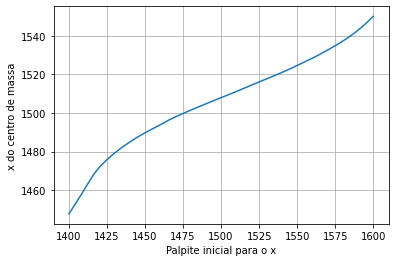

In [60]:
x_initial_guess = np.linspace(1400, 1600)
x_cm = [center_of_mass(image, i, 1000, 100)[0] for i in x_initial_guess]

plt.plot(x_initial_guess, x_cm)
plt.xlabel("Palpite inicial para o x")
plt.ylabel("x do centro de massa")
plt.grid()

Nesse gráfico vemos que o resultado é dependente do palpite inicial para x, mas é um pouco mais estável perto do 1510, e vai ficando menos estável conforme nos afastamos desse valor. É por essas e por outras que não se pode usar cegamente um método como o centro de massa, mas ele tem a sua utilidade se estivermos atentos às suas limitações.

## Ajuste de um centroide

Agora que já fizemos umas experiências com o centro de massa, vamos tentar algo um pouco mais sofisticado, que envolve o ajuste de uma função aos dados.
Ao contrário do centro de massa, que não faz nenhuma suposição a respeito da distribuição de brilho da galáxia, o ajuste de uma função supõe que existe alguma forma analítica que aproxima razoavelmente bem as observações.

Primeiro vamos ver um corte da imagem em apenas uma direção, por exemplo, ao longo de uma linha ou coluna.
Como já temos um palpite para o centro que obtivemos a partir do centro de massa, podemos usar estas coordenadas como base.
Vejamos a coluna 1510.

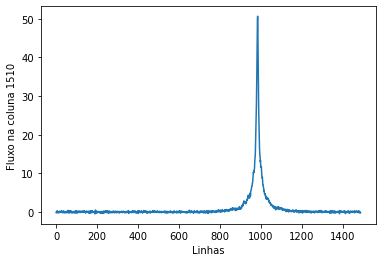

In [61]:
plt.plot(image[:, 1510])
plt.xlabel('Linhas')
plt.ylabel('Fluxo na coluna 1510')
plt.show()

Certo, apareceu ali um pico quase na linha 1000, que era o que esperávamos.
Contudo, obvervando com cuidado a base do gráfico notamos que há muito ruído nos dados.
Para diminuir o efeito do ruído podemos fazer uma média de algumas colunas, ao invés de tomar uma só.

Text(0, 0.5, 'Fluxo médio entre as colunas 1500 e 1520')

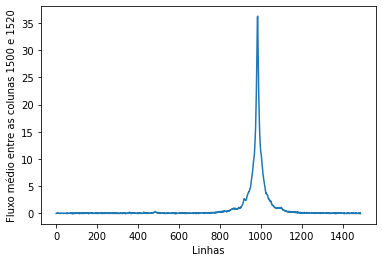

In [62]:
plt.plot(image[:, 1500:1520].mean(axis=1))
plt.xlabel('Linhas')
plt.ylabel('Fluxo médio entre as colunas 1500 e 1520')

Vamos tentar olhar mais de perto a galáxia, que é este pico perto da linha mil.

Text(0, 0.5, 'Fluxo médio entre as colunas 1500 e 1520')

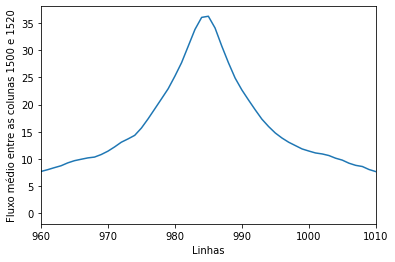

In [63]:
plt.plot(image[:, 1500:1520].mean(axis=1))
plt.xlim(985 - 25, 985 + 25)
plt.xlabel('Linhas')
plt.ylabel('Fluxo médio entre as colunas 1500 e 1520')

Talvez uma parábola sirva para representar a parte central dessa curva. 
Tem que ser uma parábola com o coeficiente de $x^2$ negativo, obviamente, e também não podemos ir para muito longe do ponto central, por que a função vai ficar muito negativa.

$$ f(x) = -a (x - x_0) ^2 + y_0 $$

Assim, ao invés de utilizarmos todo o espaço possível para fazer o ajuste, vamos nos ater a um pedacinho bem próximo do pico, indo só 5 pixeis para cada lado.
Para deixar claro que não estamos interessados em valores negativos, já vamos truncar a função, adicionando um comando para igualar a zero qualquer valor negativo.

Text(0, 0.5, 'Fluxo médio entre as colunas 1500 e 1520')

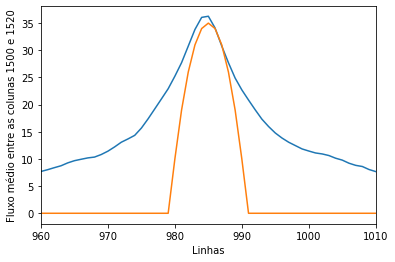

In [64]:
def quadratic(x, x0, a, y0):
    y = - a * (x - x0)**2 + y0
    y[y < 0] = 0
    return y

fig, ax = plt.subplots()
x = np.arange(950, 1100)
ax.plot(image[:, 1500:1520].mean(axis=1))
ax.plot(x, quadratic(x, 985, 1, 35))
ax.set_xlim(985 - 25, 985 + 25)
ax.set_xlabel('Linhas')
ax.set_ylabel('Fluxo médio entre as colunas 1500 e 1520')

Até que não está tão mal.
Vamos tentar fazer o ajuste.

Ajustar uma função é o processo de encontrar os parâmetros que minimizam alguma figura de mérito, frequentemente o $\chi^2$.
Os detalhes deixaremos para um segundo momento, por enquanto só nos interessa saber que é possível utilizar a função `curve_fit` para ajustar uma função.
A `curve_fit` toma como entrada a função que desejamos ajustar (a `quadratic` que acabamos de definir), os dados observados, e um palpite inicial para os parâmetros.
Olhando para o gráfico acima parece que um bom palpite deve é $x_0 = 985, a = 1, y_0 = 35$.

Linha central: 984.4886


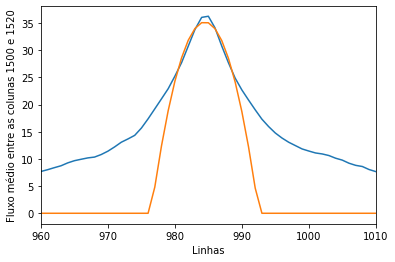

In [65]:
from scipy.optimize import curve_fit
p, covariance = curve_fit(quadratic, xdata=np.arange(980, 990), ydata=image[980:990, 1500:1520].mean(axis=1), p0=[985, 1, 35]) 

fig, ax = plt.subplots()
x = np.arange(900, 1100)
ax.plot(image[:, 1500:1520].mean(axis=1))
ax.plot(x, quadratic(x, *p))
ax.set_xlim(985 - 25, 985 + 25)
ax.set_xlabel('Linhas')
ax.set_ylabel('Fluxo médio entre as colunas 1500 e 1520')

print(f'Linha central: {p[0]:.4f}')

Ótimo!
O ajuste nos diz que o melhor valor para a coordenada do centro da galáxia é $x_0 = 984.49$.
Até que não está ruim, mas talvez tenha uma função melhor do que essa parábola, por exemplo uma gaussiana.

$$ f(x) = A \exp \left[ - \frac{(x - x_0)^2}{2\sigma^2} \right] $$

Linha central: 984.4916


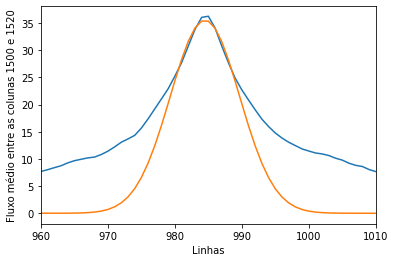

In [66]:
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / 2.0 / sigma**2)

p, covariance = curve_fit(gaussian, xdata=np.arange(980, 990), ydata=image[980:990, 1500:1520].mean(axis=1), p0=[35.0, 985.0, 10]) 

fig, ax = plt.subplots()
x = np.arange(900, 1100)
ax.plot(image[:, 1500:1520].mean(axis=1))
ax.plot(x, gaussian(x, *p))
ax.set_xlim(985 - 25, 985 + 25)
ax.set_xlabel('Linhas')
ax.set_ylabel('Fluxo médio entre as colunas 1500 e 1520')

print(f'Linha central: {p[1]:.4f}')

É muito pouca diferença, mas vale a pena ficar com a Gaussiana por que pelo menos ela nos poupa o trabalho de truncar a parábola.
Existem outros motivos que fazem da Gaussiana uma função mais adequada, para saber mais sobre esse assunto pesquise sobre *Point Spread Function*.

Mesmo que a função Gaussiana seja a mais apropriada, dá para ver que ela ainda assim não representa bem o perfil de brilho da galáxia.
Talvez um passo simples que possamos dar agora seja ajustar a soma de duas Gaussianas: uma mais estreita, representando esse pico central, e outra mais larga representando as asas que vemos abaixo de 970 e acima de 1000.
Para isto basta modificar a nossa função anterior, adicionando mais dois parâmetros, e pedindo que ela retorne a soma de duas Gaussianas, cada uma com amplitude e $\sigma$ próprios.

$$ f(x) = A \exp \left[ -\frac{(x - x_0)^2}{2\sigma_a^2}\right]
+ B \exp \left[ -\frac{(x - x_0)^2}{2\sigma_b^2}\right] $$

A = 10.83
B = 22.82
x0 = 984.50
sigma_a = 32.48
sigma_b = 5.42

 Linha central: 984.5036


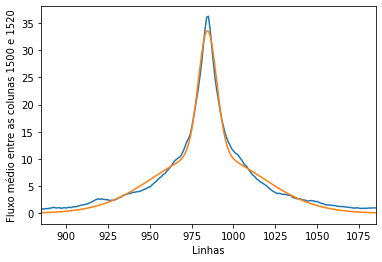

In [67]:
def gaussian2(x, a, b, x0, sigma_a, sigma_b):
    g1 = a * np.exp(-(x - x0)**2 / 2.0 / sigma_a**2)
    g2 = b * np.exp(-(x - x0)**2 / 2.0 / sigma_b**2)
    g = g1 + g2
    return g

x_low, x_up = 0, 1200
p, covariance = curve_fit(gaussian2, xdata=np.arange(0, 1200), ydata=image[0:1200, 1500:1520].mean(axis=1), p0=[10.0, 10.0, 985.0, 10.0, 10.0]) 

for i, j in zip("A B x0 sigma_a sigma_b".split(), p): 
    print(f"{i} = {j:.2f}")

fig, ax = plt.subplots()
x = np.arange(x_low, x_up)
ax.plot(image[:, 1500:1520].mean(axis=1))
ax.plot(x, gaussian2(x, *p))
ax.set_xlim(985 - 100, 985 + 100)
ax.set_xlabel('Linhas')
ax.set_ylabel('Fluxo médio entre as colunas 1500 e 1520')

print(f'\n Linha central: {p[2]:.4f}')

Beeeeem melhor!
Esse gráfico mostra uma coisa interessantíssima: a distribuição de brilho dessa galáxia é razoavelmente bem descrita por duas funções, uma mais alongada e outra mais concentrada no núcleo.
Não é mera coincidência.
Galáxias espirais realmente possuem um perfil de brilho que é basicamente o resultado de duas componentes, o bojo e o disco!
Contudo, as funções que descrevem essas duas componentes não são Gaussianas, elas tem uma raiz física muito bem fundamentada e que tem a ver com a maneira como as estrelas se organizam no potencial gravitacional da galáxia, e qual é a distribuição de suas órbitas.

As órbitas das estrelas do disco estão preferencialmente em um mesmo plano, ou seja, a componente vertical da velocidade das estrelas é relativamente pequena.
O disco é parecido análogo ao sistema solar, no sentido que todos os planetas orbitam o Sol mais ou menos no mesmo plano.
Já o bojo é uma estrutura esferoidal.
As órbitas das estrelas ali estão em diversos planos; pode ter uma estrela no plano $yz$, outra no $xy$ e outra no $xz$.

Voltando ao nosso exercício, que tal colocar tudo isso na forma de uma função?
Nessa função vamos fazer uso de parâmetros que possuem valores padrão.
Parâmetros que possuem um valor padrão na definição da função podem ser omitidos quando a função é invocada.
No exemplo abaixo o parâmetro `line` possui o valor padrão `1510`, ou seja, se na chamada para a função nada for dito a respeito do parâmetro `line`, este parâmetro receberá o valor `1510`.

Parâmetros (também chamados de argumentos) que possuem um valor padrão são ditos opcionais, já que a função funcionará mesmo que eles não sejam declarados.

**Importante**: Note que nesta função estamos usando uma função como argumento! O parâmetro `fun`, que além de ser muito divertido é uma contração de *function*, recebe como entrada o nome de uma função previamente definida. No caso estamos dizendo que o padrão é usar a `gaussian2`, mas poderia perfeitamente ser a `quadratic` ou a `gaussian`, só teríamos que adaptar o chute inicial `p0` para o número correto de parâmetros.

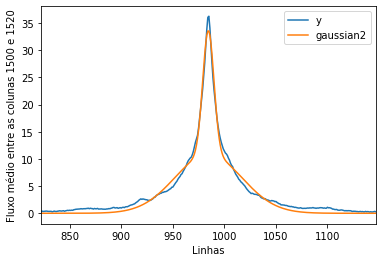

In [68]:
def centroid_gaussian(x, y, fun=gaussian2, line=1510, width=10, p0=[10, 10, 985, 2, 10], plot=False):

    p, covariance = curve_fit(fun, xdata=x, ydata=y, p0=p0)

    if plot:
        fig, ax = plt.subplots()
        ax.plot(y, label='y')
        ax.plot(x, fun(x, *p),label='gaussian2')
        ax.set_xlim(p[2] - (5 * p[4]), p[2] + (5 * p[4]))
        ax.set_xlabel('Linhas')
        ax.set_ylabel('Fluxo médio entre as colunas 1500 e 1520')
        plt.legend()
        plt.show()

    return p

centroid_gaussian(x=np.arange(image.shape[0]), y=image[:, 1500:1520].mean(axis=1), plot=True)
print()

In [69]:
centroid_gaussian(x=np.arange(image.shape[0]), y=image[:, 1510 - 200:1510 + 200].mean(axis=1), p0=[10.0, 10.0, 1000, 5.0, 20.0])

array([  2.2061405 ,   1.18596998, 984.69445594,  19.70928885,
        86.40635851])

média: 984.76
desvio padrão: 0.04


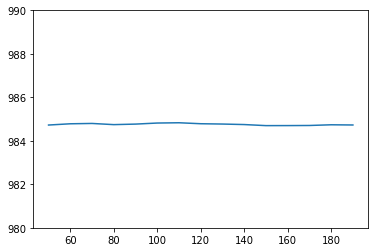

In [70]:
w = np.arange(50, 200, 10)
c = np.array([centroid_gaussian(x=np.arange(image.shape[0]), y=image[:, 1510 - _:1510 + _].mean(axis=1))[2] for _ in w])
plt.plot(w, c)
plt.ylim(980, 990)
print(f"média: {c.mean():.2f}")
print(f"desvio padrão: {c.std():.2f}")

Agora sim!
Mudamos a nossa janela de investigação entre 100 e 400 pixeis e o resultado continua em $984.76 \pm 0.04$.
Isso quer dizer que a nossa solução não depende, ou depende muito pouco, da maneira como montamos o problema.
Podemos escolher um janela de 100 pixeis para cada lado, para utilizar um bom pedaço da galáxia na estimativa.

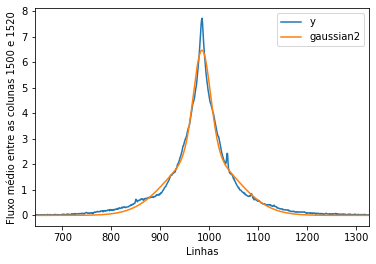

Coordenada y do centroide: 984.8 pixeis


In [71]:
c = centroid_gaussian(x=np.arange(image.shape[0]), y=image[:, 1510 - 100:1510 + 100].mean(axis=1), plot=True)
print(f"Coordenada y do centroide: {c[2]:.1f} pixeis")

Será que depende do palpite inicial?
Vamos variar o palpite inicial para o centro das Gaussianas entre 900 e 1100.

média: 984.69
desvio padrão: 0.00


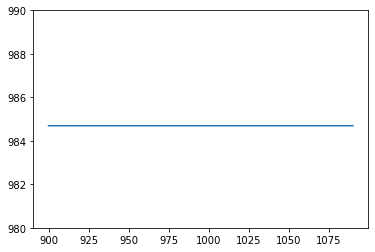

In [72]:
w = np.arange(900, 1100, 10)
c = np.array([centroid_gaussian(x=np.arange(image.shape[0]), y=image[:, 1510 - 200:1510 + 200].mean(axis=1), p0=[10.0, 10.0, _, 5.0, 20.0])[2] for _ in w])
plt.plot(w, c)
plt.ylim(980, 990)
print(f"média: {c.mean():.2f}")
print(f"desvio padrão: {c.std():.2f}")

Desvio padrão zero! Quer dizer que a solução é estável independentemente do palpite inicial.

Bom, depois de todo esse esforço conseguimos escrever uma singela funçãozinha que consegue nos dizer qual é o centroide de uma galáxia a partir de um chute meio tosco, e de uma janela que não inclua muito mais do que a própria galáxia.

Durante a jornada aprendemos a trabalhar com arrays, fazer ajustes rudimentares e escrever as nossas próprias funções.

**E o mais importante: aprendemos que o perfil de brilho das galáxias espirais revela que elas possuem pelo menos duas componentes distintas, um bojo e um disco.**